In [1]:
import os
import sys
import scipy.io 
from scipy.signal import hilbert
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline
import urllib.request
import cv2 as cv

sys.path.insert(0, "\\".join(os.path.abspath(os.curdir).split("\\")[:-2:]))

from src.utils.utils import *

### Funções

In [2]:
# download images
def download_imgs(urllink, tgt_path, names):
    print('images saved to {}.'.format(tgt_path))
    
    for i, img_url in enumerate(urllink.values ):
        filename = '\\{}.jpg'.format(names[i])
        full_tgt_path = '{}{}'.format(tgt_path, filename)
        urllib.request.urlretrieve(img_url, full_tgt_path)

### OASBUD

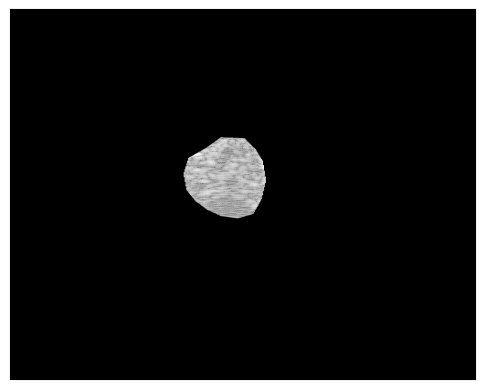

In [10]:
path = "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\OASBUD"
data = scipy.io.loadmat(path + '\\OASBUD.mat')

# Definir as variáveis
c = 1540  # Velocidade do som em m/s (1540 m/s)
width = 38  # Largura da abertura em mm (38 mm)
fs = 40e6  # Frequência de amostragem em Hz (40 MHz)

metadata = {'id': [], 'pathology': [], 'bi-rads': [], 'image_path': [], 'roi_image_path': [], 'image_size_mb': []}

for study in data['data'][0]:
    i = 0
    study_id = study[0][0]
    folder_path = path + "\\images\\" + study_id
    
    # Criar a pasta para salvar as imagens
    if not os.path.exists(folder_path):
        os.mkdir(folder_path)
    
    for rf, roi in zip([study[1], study[2]], [study[3], study[4]]):
        metadata['id'].append(f'{study_id}_{i}')
        metadata['bi-rads'].append(study[5][0][0])
        metadata['pathology'].append(study[6][0][0])
        
        # Calcular os eixos z e y
        rf_shape = rf.shape
        z_axis = 1000 * np.linspace(0, rf_shape[0] * 0.5 * c / fs, rf_shape[0])  # Profundidade em mm
        y_axis = np.linspace(0, width, rf_shape[1])  # Largura em mm

        # Calcular a imagem de envelope
        envelope_image = 20 * np.log10(np.abs(np.apply_along_axis(lambda x: hilbert(x), 0, rf)))
        envelope_image = envelope_image * roi
    
        # Criar o gráfico de escala de cinza
        im = plt.imshow(envelope_image, cmap='gray', extent=[y_axis[0], y_axis[-1], z_axis[-1], z_axis[0]])
        cbar = plt.colorbar(im)
        cbar.remove()  # Remove a barra de cores
        plt.clim(40, 80)  # Define o intervalo de cores
        
        # Remover os rótulos dos eixos x e y
        plt.xticks([])
        plt.yticks([])
        
        # Salva a imagem original
        plt.savefig(f'{folder_path}\\{study_id}_{i}.png', bbox_inches='tight', pad_inches=0)
        metadata['image_path'].append(f'{folder_path}\\{study_id}_{i}.png')
        metadata['image_size_mb'].append(get_images_size(f'{folder_path}\\{study_id}_{i}.png', "png", False))
        
        # salva a imagem com a ROI
        envelope_image = envelope_image * roi
        im = plt.imshow(envelope_image, cmap='gray', extent=[y_axis[0], y_axis[-1], z_axis[-1], z_axis[0]])
        plt.savefig(f'{folder_path}\\{study_id}_{i}_roi.png', bbox_inches='tight', pad_inches=0)
        metadata['roi_image_path'].append(f'{folder_path}\\{study_id}_{i}_roi.png')
        
        i += 1
              
df = pd.DataFrame(metadata)
df['pathology'] = df['pathology'].map({0: 'benign', 1: 'malignant'})
df.to_csv("../../outputs/ultrassom/metadata_oasbud.csv", index=False)

### HMSS

#### Configurações inciais

In [11]:
path = "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\HMSS"

if not os.path.exists(path):
    os.mkdir(path)

ds = pd.read_csv(f"{path}\\HMSS_raw.csv" ) # change back to HMSS.csv at the end
ROOT = 'https://www.ultrasoundcases.info'
#urllinkcover = ROOT+url.casecoverimage
urllinkimage = ROOT + ds['img url']

#CaseCoverName = url.CaseCoverName
img_names = ds['img name']

#### Baixar as imagens, recortar e salvar os metadados

In [12]:
# cropping images
def cropping_Images(ds, src_path, names, tgt_path):
    '''
    '''
    rw1 = ds['crop r1']  # top bound
    rw2 = ds['crop r2']  # bottom bound
    cl1 = ds['crop col1']  # left bound
    cl2 = ds['crop col2']  # right bound

    for i, name in enumerate(names):
        r1 = rw1[i]
        r2 = rw2[i]+r1
        c1 = cl1[i]
        c2 = cl2[i]+c1

        tmp_img = cv.imread(Path.join(src_path, str(name)+'.jpg'))
        img = tmp_img[r1:r2, c1:c2]

        cv.imwrite(os.path.join(tgt_path, str(name)+'.jpg'), img)
        print(i, 'crop ', str(name)+'.jpg', tmp_img.shape,
            '-->', img.shape, str(name)+'.jpg')

#sendLinks(urllink, PathImages, imagenames)
download_imgs(urllinkimage, path+'\\images', img_names)
# cropping images(dataset, source path, image names, target path)
cropping_Images(ds, path+'\\images', img_names, path+'\\images')

# Salvar os metadados
metadata_csv = ds[['img name', 'group', 'subgroup', 'subgroup url', 'case description', 'img url']].copy()
metadata_csv.loc[:, 'image_path'] = f'{path}\\images\\' + metadata_csv['img name'] + '.jpg'
metadata_csv['pathology'] = ds['tumor type'].str.capitalize()
metadata_csv.rename(columns={'img name': 'id', 'subgroup url': 'subgroup_url', 'img url': 'image_url', 
                             'case description': 'findings_notes', }, inplace=True)

images_size = get_images_size(path, "jpg", True)
metadata_csv['image_size_mb'] = images_size
metadata_csv['pathology'] = metadata_csv['pathology'].map({'Benign': 'benign', 'Malignant': 'malignant'})

metadata_csv.to_csv("../../outputs/ultrassom/metadata_hmss.csv", index=False)

images saved to D:\mathe\Documents\banco_dados_ic\ultrassom\HMSS\images.


### Thammasat

#### Configurações

In [2]:
# Reading csv file and parsing columns
path = "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\Thammasat"
tgt_path = path + "\\images"

if not os.path.exists(tgt_path):
    os.mkdir(tgt_path)

ds = pd.read_csv(f"{path}\\Thammasat_raw.csv" ) # change back to HMSS.csv at the end")

urls = ds['img url']
img_names = ds['img name']

#### Baixar, recortar as imagens e salvar os metadados 

In [3]:
def cropping_Images(ds, src_path, names, tgt_path):
    '''
    '''
    rw1 = ds['crop r1'] # top bound
    rw2 = ds['crop r2'] # bottom bound
    cl1 = ds['crop col1'] # left bound
    cl2 = ds['crop col2'] # right bound
    
    for i, name in enumerate(names):
        r1 = rw1[i]-1
        r2 = rw2[i]-1
        c1 = cl1[i]-1
        c2 = cl2[i]-1
        
        tmp_img = cv.imread(os.path.join(src_path,name+'.jpg'))
        img = tmp_img[r1:r2,c1:c2]
        
        cv.imwrite(os.path.join(tgt_path, name+'.jpg'), img)
        print(i, 'crop ', name+'.jpg', tmp_img.shape, '-->', img.shape, name+'.jpg')

#sendLinks(urllink, PathImages, imagenames)
download_imgs(urls, tgt_path, img_names)
# cropping images(dataset, source path, image names, target path)
cropping_Images(ds, tgt_path, img_names, tgt_path)

# Salvar os metadados
metadata_csv = ds[['img name', 'img url']].copy()
metadata_csv.loc[:, 'image_path'] = f'{tgt_path}\\' + metadata_csv['img name'] + '.jpg'
metadata_csv['pathology'] = ds['tumor type']
metadata_csv.rename(columns={'img name': 'id', 'img url': 'image_url'}, inplace=True)

images_size = get_images_size(path, "jpg", True)
metadata_csv['image_size_mb'] = images_size

metadata_csv.to_csv("../../outputs/ultrassom/metadata_thammasat.csv", index=False)

### BUSI

In [3]:
path_dataset = "D:\\mathe\\Documents\\Banco_dados_ic\\ultrassom\\Dataset_BUSI_with_GT"
folders = ['benign', 'malignant', 'normal']
dict_count_pathology = {}
dict_pathology = []

for pathology in folders:
    path = path_dataset + f"\{pathology}"
    
    original = [img for img in os.listdir(path) if "mask" not in img]
    roi = [img for img in os.listdir(path) if "mask" in img]
    
    for img_name, cropp_name in zip(original, roi):
        study = {'id': img_name.replace(".png", "").replace(" ", "_").replace("(", "").replace(")", ""), 
                 'image_path': path + f"\{img_name}",
                 'roi_image_path': path + f"\{cropp_name}",
                 'pathology': pathology,
                 'image_size_mb': get_images_size(path + f"\{img_name}", "png", False)}
        
        dict_pathology.append(study)
        
metadata_csv = pd.DataFrame(dict_pathology)
metadata_csv.to_csv("../../outputs/ultrassom/metadata_busi.csv", index=False)

### Ultrasound Breast Classification

In [4]:
path_dataset = "D:\\mathe\\Documents\\banco_dados_ic\\ultrassom\\ultrasound_breast_classification"
dict_pathology = []

for part in ['train', 'val']:
    for pathology in ['benign', 'malignant']:
        path = path_dataset + f'\{part}\{pathology}'
        
        images = os.listdir(path)
        
        for img_name in images:
            study = {'id': img_name.replace(".png", "").replace(" ", "_").replace("(", "").replace(")", ""), 
                 'image_path': path + f"\{img_name}",
                 'pathology': pathology.lower(),
                 'image_size_mb': get_images_size(path + f"\{img_name}", "png", False)}
            
            dict_pathology.append(study)

metadata_csv = pd.DataFrame(dict_pathology)
metadata_csv.to_csv("../../outputs/ultrassom/metadata_ultrasound_breast_classification.csv", index=False)

print(f"Benign: {metadata_csv[metadata_csv['pathology'] == 'benign'].shape[0]}")
print(f"Malignant: {metadata_csv[metadata_csv['pathology'] == 'malignant'].shape[0]}")

Benign: 4574
Malignant: 4442
